In [1]:
import pathlib
data_root = f"{pathlib.Path.home()}/Projects/AI-ML/datasets"

from io import open
import glob
import os

def findFiles(path): return glob.glob(f"{data_root}/{path}")

names_path = 'nlp_data/names/*.txt'
# print(findFiles(names_path))

In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [3]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(names_path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

![RNN](images/char-rnn-name-gen.png)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RnnCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim) -> None:
        super().__init__()

        self.i2h = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.i2o = nn.Linear(input_dim + hidden_dim, output_dim)
        self.c2o = nn.Linear(output_dim + hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, hidden):
        x = torch.cat((x, hidden), dim=-1)
        hidden = self.i2h(x)
        output = self.i2o(x)
        output = self.c2o(torch.cat((output, hidden), dim=-1))
        # hidden = F.tanh(hidden)
        output = self.dropout(output)
        return output, hidden

In [5]:
class CharRnnGenerator(nn.Module):

    def __init__(self, n_categories, vocab_size, embedding_size, hidden_dim) -> None:
        super().__init__()

        self.n_categories = n_categories
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.cell = RnnCell(input_dim=(n_categories + embedding_size), hidden_dim=hidden_dim, output_dim=vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def step_forward(self, category, idx, hidden):
        category_embedded = F.one_hot(category, num_classes=self.n_categories)
        # print("Cat:", category_embedded.shape)
        embedded = self.embedding(idx).squeeze(-2)
        # print("embedded:", embedded.shape)
        embedded = torch.cat((category_embedded, embedded), dim=-1)
        # print("combined:", embedded.shape)
        output, hidden = self.cell(embedded, hidden)
        output = self.softmax(output)
        return output, hidden


    def forward(self, category, idx, hidden = None):
        outputs = []
        if hidden is None:
            hidden = torch.zeros(self.hidden_dim)
        for t in range(len(idx)):
            output, hidden = self.step_forward(category, idx[t].unsqueeze(-1), hidden)
            outputs.append(output)
        return torch.stack(outputs, dim=-2), hidden

In [6]:
rnn = CharRnnGenerator(10, 20, 16, 32)

category = torch.tensor(2)
sentence = torch.tensor([1, 2, 19, 0])
rnn(category, sentence)

(tensor([[-2.9207, -2.9462, -3.0034, -2.9935, -2.8856, -2.8475, -3.1176, -3.3416,
          -2.6819, -2.9302, -2.9145, -3.0256, -3.0074, -3.2878, -2.9096, -2.9716,
          -3.0256, -3.1032, -2.9462, -3.2873],
         [-2.9800, -2.8762, -2.8858, -2.9800, -2.8201, -3.3205, -2.9467, -3.2323,
          -2.9925, -2.9800, -3.0458, -2.8274, -3.0337, -3.1276, -2.9800, -3.1157,
          -2.7925, -3.1602, -2.8344, -3.1858],
         [-2.9920, -2.8282, -2.9862, -2.8748, -3.1102, -3.3426, -3.1190, -3.0662,
          -2.6988, -2.7994, -3.2103, -2.9920, -3.1326, -3.0184, -2.7876, -3.0056,
          -2.9590, -3.0079, -2.9920, -3.2345],
         [-3.1938, -2.7829, -3.2696, -3.2340, -2.7266, -2.9555, -3.0358, -3.2555,
          -3.1073, -2.7335, -3.2650, -3.1148, -2.6972, -2.9769, -2.8709, -3.1482,
          -2.8802, -2.9790, -3.1787, -2.8685]], grad_fn=<StackBackward0>),
 tensor([ 0.0864, -0.2910,  0.0039,  0.1051,  0.1509, -0.1673,  0.3400,  0.0071,
          0.2174,  0.6348, -0.0426, -0.3349, -0

In [7]:
torch.tensor(2)

tensor(2)

In [8]:
F.one_hot(torch.tensor([2]), 3)

tensor([[0, 0, 1]])

In [9]:
category2index = {c: i for i, c in enumerate(all_categories)}

EoS = '<E>'
letter2index = {c: (i+1) for i, c in enumerate(all_letters)}
letter2index[EoS] = 0

index2letter = {(i+1): c for i, c in enumerate(all_letters)}
index2letter[0] = EoS

print(index2letter[letter2index['F']])

F


In [10]:
import random


def category2tensor(category):
    return torch.tensor(category2index[category], dtype=torch.long)

def name2tensor(name):
    return torch.tensor([letter2index[EoS]] + [letter2index[l] for l in name] + [letter2index[EoS]], dtype=torch.long)

def trainingPair(name):
    tensor = name2tensor(name)
    return tensor[:-1], tensor[1:]

def randomChoice(data):
    return data[random.randint(0, len(data) - 1)]

def randomTrainingSample():
    category = randomChoice(all_categories)
    name = randomChoice(category_lines[category])
    inputs, targets = trainingPair(name)
    return category2tensor(category), inputs, targets, (category, name)

In [11]:
cat_tensor, inputs, targets, (category, name) = randomTrainingSample()
print(cat_tensor.shape, inputs.shape, targets.shape, category, name)

torch.Size([]) torch.Size([5]) torch.Size([5]) Chinese Kong


In [12]:
hidden_dim = 128
embedding_size = 30
gen_rnn = CharRnnGenerator(n_categories=len(all_categories), vocab_size=len(index2letter), embedding_size=embedding_size, hidden_dim=hidden_dim)

criterion = nn.NLLLoss(reduction='sum')

In [13]:
criterion(gen_rnn(cat_tensor, inputs)[0], targets)

tensor(21.1224, grad_fn=<NllLossBackward0>)

In [14]:
learning_rate = 0.0005

def train(category_tensor, inputs, targets):
    gen_rnn.zero_grad()
    
    outputs, _ = gen_rnn(category_tensor, inputs)
    loss = criterion(outputs, targets)
    loss.backward()

    for p in gen_rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return outputs, loss.item() / len(inputs)


In [15]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [16]:
n_iters = 150000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    cat_tensor, inputs, targets, (category, name) = randomTrainingSample()
    output, loss = train(cat_tensor, inputs, targets)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 17s (5000 3%) 2.5863
0m 30s (10000 6%) 2.3520
0m 50s (15000 10%) 2.7679
1m 2s (20000 13%) 2.5211
1m 12s (25000 16%) 2.2557
1m 21s (30000 20%) 2.2887
1m 29s (35000 23%) 1.8380
1m 37s (40000 26%) 2.6742
1m 46s (45000 30%) 2.0871
1m 54s (50000 33%) 2.7062
2m 2s (55000 36%) 2.7252
2m 11s (60000 40%) 3.0959
2m 20s (65000 43%) 2.2097
2m 29s (70000 46%) 2.9995
2m 37s (75000 50%) 1.8083
2m 46s (80000 53%) 1.9534
2m 54s (85000 56%) 3.1691
3m 2s (90000 60%) 2.8650
3m 10s (95000 63%) 3.0032
3m 18s (100000 66%) 2.2700
3m 27s (105000 70%) 2.6023
3m 36s (110000 73%) 3.0237
3m 46s (115000 76%) 2.5228
3m 56s (120000 80%) 2.5308
4m 5s (125000 83%) 2.3719
4m 13s (130000 86%) 1.8973
4m 22s (135000 90%) 1.8908
4m 30s (140000 93%) 2.2786
4m 38s (145000 96%) 2.3726
4m 46s (150000 100%) 1.8764


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

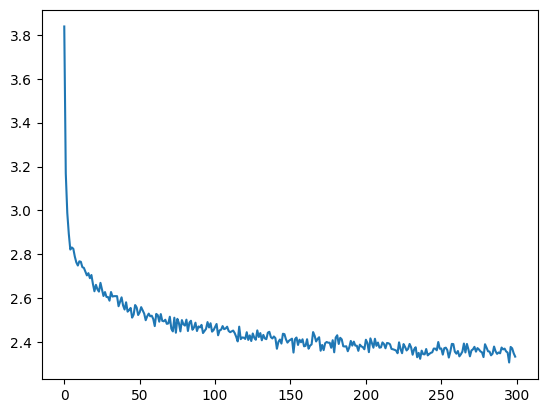

In [18]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [19]:
max_length = 20

def letter2tensor(l):
    return torch.tensor([letter2index[l]], dtype=torch.long)

# Sample from a category and starting letter
def sample(category):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = category2tensor(category)
        input_tensor = letter2tensor(EoS)
        hidden = torch.zeros(gen_rnn.hidden_dim)
        output_name = ''

        for i in range(max_length):
            output, hidden = gen_rnn.step_forward(category_tensor, input_tensor, hidden)
            idx = torch.multinomial(output.exp(), num_samples=1, replacement=True).item()
            if idx == letter2index[EoS]:
                break
            else:
                letter = index2letter[idx]
                output_name += letter
            input_tensor = letter2tensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, n_samples):
    for _ in range(n_samples):
        print(category, sample(category))

samples('Russian', 3)

samples('German', 3)

samples('Spanish', 3)

samples('Chinese', 3)

Russian Abounnon
Russian ModXultbing
Russian BartMontkev
German Basks
German euthcVult
German Grten
Spanish Iomaraza
Spanish Davaler
Spanish Narsstopra
Chinese LiS
Chinese Fian
Chinese G.ue


In [20]:
samples('Vietnamese', 10)

Vietnamese VAng
Vietnamese Hau
Vietnamese Vann
Vietnamese Sih
Vietnamese Bo
Vietnamese Lou
Vietnamese Hhan
Vietnamese HuwPhi
Vietnamese Paynn
Vietnamese NhiiZ


In [21]:
all_categories

['Czech',
 'German',
 'Arabic',
 'Japanese',
 'Chinese',
 'Vietnamese',
 'Russian',
 'French',
 'Irish',
 'English',
 'Spanish',
 'Greek',
 'Italian',
 'Portuguese',
 'Scottish',
 'Dutch',
 'Korean',
 'Polish']

In [22]:
samples('French', 10)

French Salamal
French Omacu
French Panmmoth
French Lortseri
French Sarofe
French Sovim
French Celra
French Donov
French Bourran
French Jarisovege


In [23]:
def eval_category(category):
    total_loss = 0.0
    total_len = 0
    with torch.no_grad():
        cat_tensor = category2tensor(category)
        for name in category_lines[category]:
            inputs, targets = trainingPair(name)
            outputs, _ = gen_rnn(cat_tensor, inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_len += len(name)
        return total_loss/ total_len

In [24]:
for category in all_categories:
    print(category, eval_category(category))

Czech 3.0379206878698053
German 2.861055170154176
Arabic 2.6411040535774264
Japanese 2.802753792648994
Chinese 2.7755597403110603
Vietnamese 2.599470034577793
Russian 2.9018882356814224
French 2.754965241328475
Irish 2.6812999954223633
English 2.9993506581723226
Spanish 2.7218923292441253
Greek 2.474122554834836
Italian 2.7660614242182526
Portuguese 2.4618357668424906
Scottish 2.6463153654812306
Dutch 2.7796970514150767
Korean 2.5053731503819985
Polish 2.5906599203587994
